Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=571.694, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=565.669, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=568.487, Time=0.88 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=568.107, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=564.537, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=567.669, Time=0.06 sec


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=567.669, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=569.669, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=566.472, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=566.107, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=567.895, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit time: 4.299 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -281.268
Date:                Wed, 06 Nov 2024   AIC                            564.537
Time:                        21:45:54   BIC                            566.002
Sample:                             0   HQIC                           565.022
                                 - 33                                         
Covariance Type:                  opg  

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


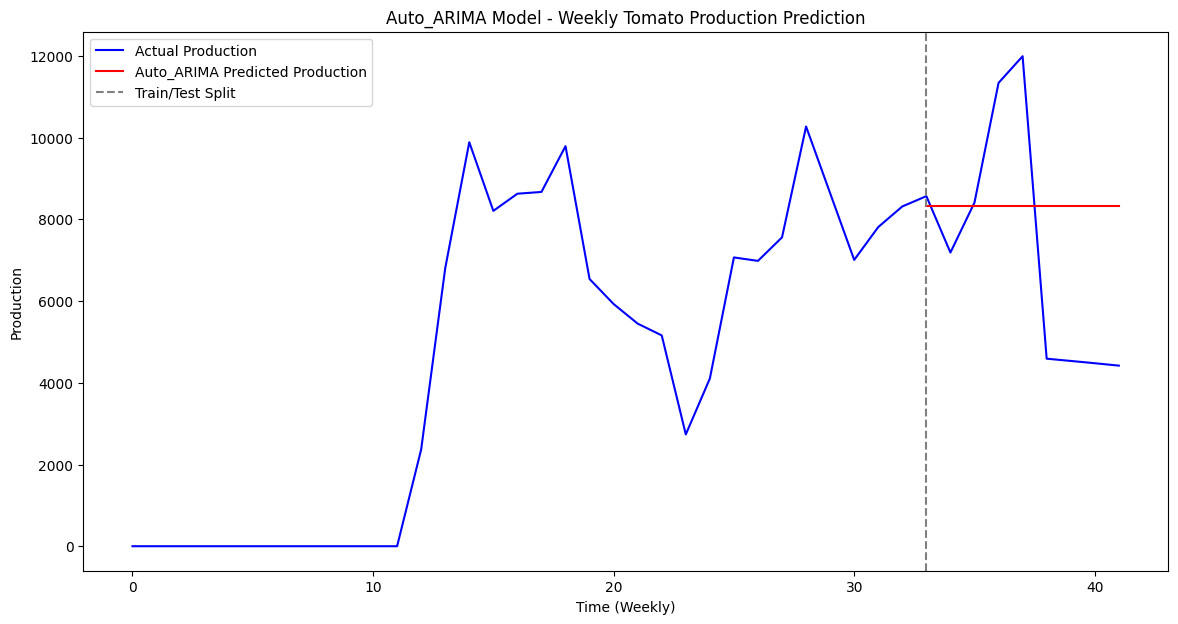

In [7]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 주차별로 평균, 최소, 최대값 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],
    'inHd': ['mean', 'min', 'max'],
    'inCo2': ['mean', 'min', 'max'],
    'outTp': ['mean', 'min', 'max']
}).reset_index()

# 열 이름을 단순화
env_weekly_features.columns = [
    '연도', '주차',
    'inTp_mean', 'inTp_min', 'inTp_max',
    'inHd_mean', 'inHd_min', 'inHd_max',
    'inCo2_mean', 'inCo2_min', 'inCo2_max',
    'outTp_mean', 'outTp_min', 'outTp_max'
]

# 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량'])

# 시계열 데이터 준비
merged_data = merged_data.sort_values(['연도', '주차']).reset_index(drop=True)
production_series = merged_data['생산량']

# 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(production_series) * 0.8)
train, test = production_series[:train_size], production_series[train_size:]

# auto_arima를 사용하여 최적의 SARIMA 파라미터 찾기
stepwise_model = auto_arima(train, 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,  # p, q의 범위를 지정하여 탐색 속도를 높임
                            seasonal=True, m=52,  # m은 계절 주기 (52주로 지정)
                            start_P=1, start_Q=1, 
                            max_P=2, max_Q=2,
                            d=1, D=0,  # D=0으로 설정하여 계절 차분을 제거
                            trace=True,  # 파라미터 선택 과정 출력
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)  # 단계적 탐색

# 최적 파라미터 확인
print(stepwise_model.summary())

# 최적 모델로 예측 수행
n_periods = len(test)
forecast = stepwise_model.predict(n_periods=n_periods)

# 실제값과 예측값 비교 그래프
plt.figure(figsize=(14, 7))
plt.plot(range(len(production_series)), production_series, label='Actual Production', color='blue')
plt.plot(range(train_size, train_size + n_periods), forecast, label='Auto_ARIMA Predicted Production', color='red')
plt.axvline(x=train_size, color='gray', linestyle='--', label='Train/Test Split')
plt.title('Auto_ARIMA Model - Weekly Tomato Production Prediction')
plt.xlabel('Time (Weekly)')
plt.ylabel('Production')
plt.legend()
plt.show()


Best ARIMA order: (0, 0, 0)
Best Seasonal order: (0, 1, 0, 52)


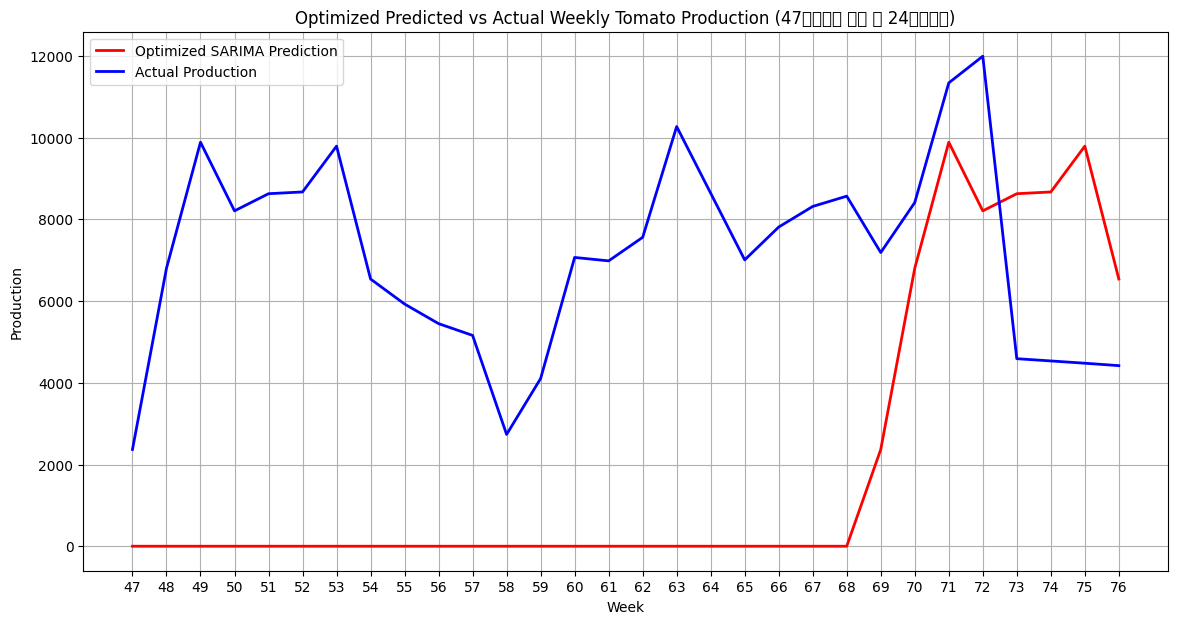

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 1. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 2. 주차별 환경 데이터의 평균, 최소, 최대값 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],      # 내부 온도 (평균, 최소, 최대)
    'inHd': ['mean', 'min', 'max'],      # 내부 습도 (평균, 최소, 최대)
    'inCo2': ['mean', 'min', 'max'],     # CO2 농도 (평균, 최소, 최대)
    'outTp': ['mean', 'min', 'max']      # 외부 온도 (평균, 최소, 최대)
}).reset_index()

# 열 이름을 단순화
env_weekly_features.columns = [
    '연도', '주차',
    'inTp_mean', 'inTp_min', 'inTp_max',       
    'inHd_mean', 'inHd_min', 'inHd_max',       
    'inCo2_mean', 'inCo2_min', 'inCo2_max',    
    'outTp_mean', 'outTp_min', 'outTp_max'     
]

# 3. 환경 데이터와 생산량 데이터를 연도와 주차를 기준으로 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})  # 열 이름 통일
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량', '면적']],  # 면적 추가
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량', '면적'])  # 결측치 제거

# 4. 병합된 데이터를 시계열 데이터로 변환하여 생산량을 학습 대상 시계열로 설정
merged_data['date'] = pd.to_datetime(merged_data['연도'].astype(str) + '-' + merged_data['주차'].astype(str) + '-1', format='%Y-%W-%w')
merged_data = merged_data.set_index('date').sort_index()
production_series = merged_data['생산량']

# ARIMA 및 SARIMA 파라미터 설정 (최적화)
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_s = 52

# 최적 파라미터 초기화
best_aic = np.inf
best_order = None
best_seasonal_order = None

# Grid Search
for param in [(x, y, z) for x in p for y in d for z in q]:
    for seasonal_param in [(x, y, z, seasonal_s) for x in seasonal_p for y in seasonal_d for z in seasonal_q]:
        try:
            # SARIMA 모델 학습
            model = SARIMAX(production_series, order=param, seasonal_order=seasonal_param, exog=merged_data[['inTp_mean', 'inHd_mean', 'inCo2_mean', 'outTp_mean']])
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best ARIMA order: {best_order}")
print(f"Best Seasonal order: {best_seasonal_order}")

# 최적 파라미터로 SARIMA 모델 학습
best_sarima_model = SARIMAX(production_series, order=best_order, seasonal_order=best_seasonal_order, exog=merged_data[['inTp_mean', 'inHd_mean', 'inCo2_mean', 'outTp_mean']])
best_sarima_result = best_sarima_model.fit()

# 예측 기간 설정: 47주차부터 다음 해 24주차까지
forecast_period = 30
forecast = best_sarima_result.get_forecast(steps=forecast_period, exog=merged_data[['inTp_mean', 'inHd_mean', 'inCo2_mean', 'outTp_mean']][-forecast_period:])
forecast_pred = forecast.predicted_mean

# 실제 데이터와 예측 데이터 비교
weeks_extended = pd.date_range(start=production_series.index[-1] + pd.Timedelta(weeks=1), periods=forecast_period, freq='W')
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended)]

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended)), forecast_pred, label='Optimized SARIMA Prediction', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended)), labels=range(47, 47 + len(weeks_extended) % 52))
plt.title('Optimized Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


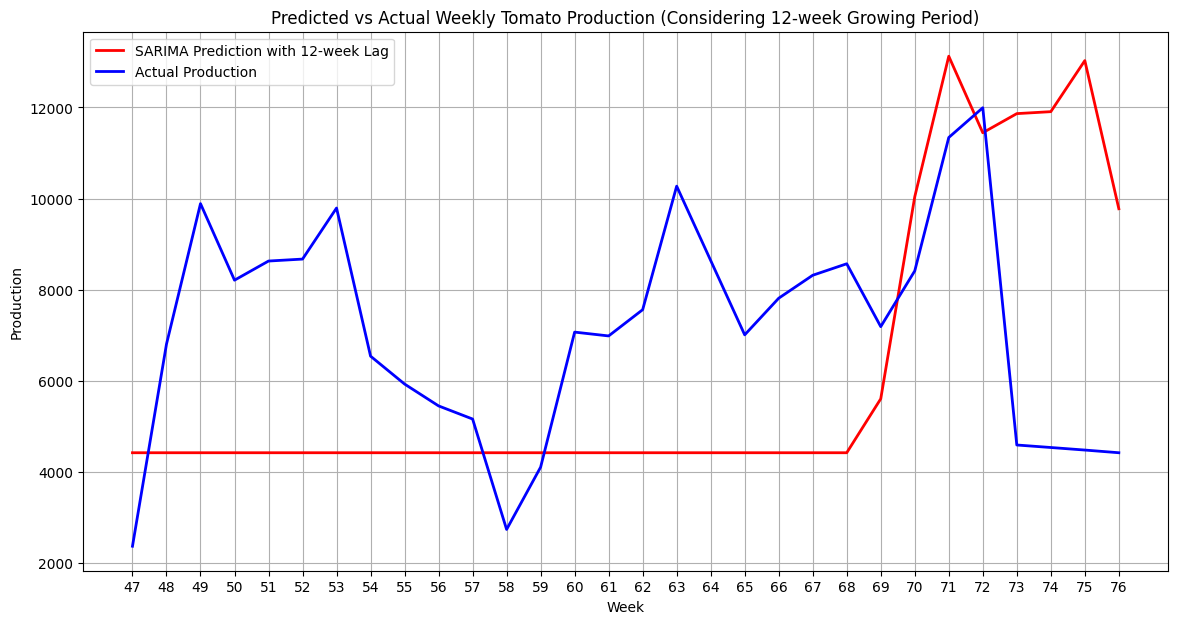

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 주차별 환경 데이터의 평균 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'mean',      # 내부 온도 평균
    'inHd': 'mean',      # 내부 습도 평균
    'inCo2': 'mean',     # CO2 농도 평균
    'outTp': 'mean'      # 외부 온도 평균
}).reset_index()

# 환경 데이터와 생산량 데이터 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})  # 열 이름 통일
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량', '면적']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량', '면적'])  # 결측치 제거

# 시계열 데이터로 변환
merged_data['date'] = pd.to_datetime(merged_data['연도'].astype(str) + '-' + merged_data['주차'].astype(str) + '-1', format='%Y-%W-%w')
merged_data = merged_data.set_index('date').sort_index()
production_series = merged_data['생산량']

# 과거 12주 평균 환경 데이터 추가
for lag in range(1, 13):
    merged_data[f'inTp_lag_{lag}'] = merged_data['inTp'].shift(lag)
    merged_data[f'inHd_lag_{lag}'] = merged_data['inHd'].shift(lag)
    merged_data[f'inCo2_lag_{lag}'] = merged_data['inCo2'].shift(lag)
    merged_data[f'outTp_lag_{lag}'] = merged_data['outTp'].shift(lag)

# 결측값 제거하여 endog와 exog의 인덱스를 맞춤
merged_data = merged_data.dropna()
production_series = merged_data['생산량']  # 결측값 제거된 생산량 시계열

# 최적 SARIMA 모델 학습
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

# SARIMA 모델 학습
sarima_model = SARIMAX(
    production_series,
    order=order,
    seasonal_order=seasonal_order,
    exog=merged_data[[f'inTp_lag_{i}' for i in range(1, 13)] +
                     [f'inHd_lag_{i}' for i in range(1, 13)] +
                     [f'inCo2_lag_{i}' for i in range(1, 13)] +
                     [f'outTp_lag_{i}' for i in range(1, 13)]]
)
sarima_result = sarima_model.fit()

# 예측 수행 (47주차부터 다음 해 24주차까지)
forecast_period = 30
forecast = sarima_result.get_forecast(steps=forecast_period, exog=merged_data[[f'inTp_lag_{i}' for i in range(1, 13)] +
                                                                              [f'inHd_lag_{i}' for i in range(1, 13)] +
                                                                              [f'inCo2_lag_{i}' for i in range(1, 13)] +
                                                                              [f'outTp_lag_{i}' for i in range(1, 13)]][-forecast_period:])
forecast_pred = forecast.predicted_mean

# 실제 데이터와 예측 데이터 비교
weeks_extended = pd.date_range(start=production_series.index[-1] + pd.Timedelta(weeks=1), periods=forecast_period, freq='W')
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended)]

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended)), forecast_pred, label='SARIMA Prediction with 12-week Lag', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended)), labels=range(47, 47 + len(weeks_extended) % 52))
plt.title('Predicted vs Actual Weekly Tomato Production (Considering 12-week Growing Period)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few ob

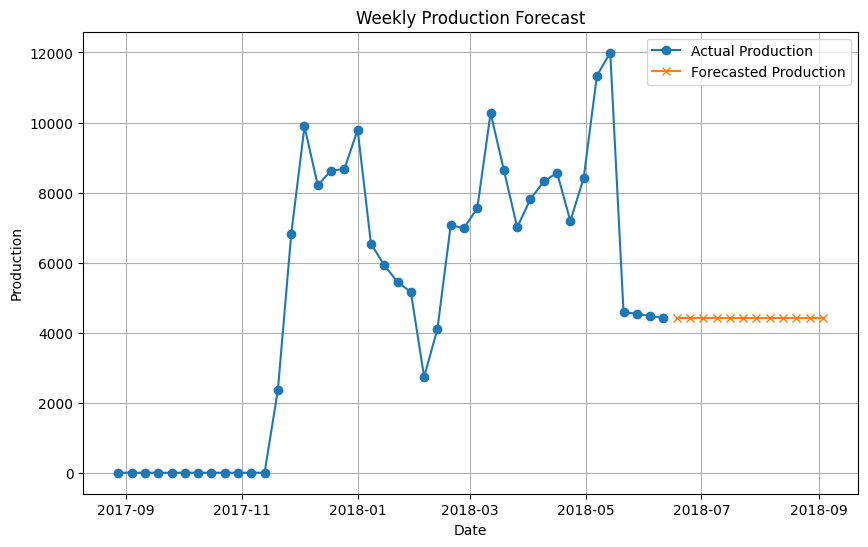

         date  predicted_production
0  2018-06-18                4420.0
1  2018-06-25                4420.0
2  2018-07-02                4420.0
3  2018-07-09                4420.0
4  2018-07-16                4420.0
5  2018-07-23                4420.0
6  2018-07-30                4420.0
7  2018-08-06                4420.0
8  2018-08-13                4420.0
9  2018-08-20                4420.0
10 2018-08-27                4420.0
11 2018-09-03                4420.0


In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1. CSV 파일 불러오기
production_data = pd.read_csv('전북군산생산량_변환.csv')
environment_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 형식 변환 및 주차 추출
environment_data['measDtStr'] = pd.to_datetime(environment_data['measDtStr'], format='%Y%m%d%H%M%S')
environment_data['연도'] = environment_data['measDtStr'].dt.year
environment_data['주차'] = environment_data['measDtStr'].dt.isocalendar().week

# 3. 열 이름 통일 (병합을 위해)
environment_data.rename(columns={'frmhsId': 'item.frmhsId'}, inplace=True)

# 4. 주간 단위로 환경 데이터 평균값 계산
weekly_env_data = environment_data.groupby(['연도', '주차', 'item.frmhsId']).mean(numeric_only=True).reset_index()

# 5. 생산량 데이터와 환경 데이터를 병합
merged_data = pd.merge(production_data, weekly_env_data, how='inner', on=['연도', '주차', 'item.frmhsId'])

# 6. 주간 생산량 시계열 데이터 준비
merged_data['date'] = pd.to_datetime(merged_data['연도'].astype(str) + '-' + merged_data['주차'].astype(str) + '-1', format='%Y-%W-%w')
weekly_production = merged_data[['date', '생산량']].groupby('date').sum().reset_index()
weekly_production.set_index('date', inplace=True)

# 7. SARIMA 모델 학습 및 예측
model = SARIMAX(weekly_production['생산량'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_model = model.fit()

# 8. 향후 12주 예측
forecast = sarima_model.forecast(steps=12)
forecast_df = forecast.reset_index()
forecast_df.columns = ['date', 'predicted_production']

# 9. 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(weekly_production.index, weekly_production['생산량'], label='Actual Production', marker='o')
plt.plot(forecast_df['date'], forecast_df['predicted_production'], label='Forecasted Production', marker='x')
plt.title('Weekly Production Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# 10. 예측 결과 출력
print(forecast_df)


c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observa

Best SARIMA Parameters: (0, 0, 0, 0, 1, 0, 52)


c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\a\anaconda3\envs\jungwoo2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


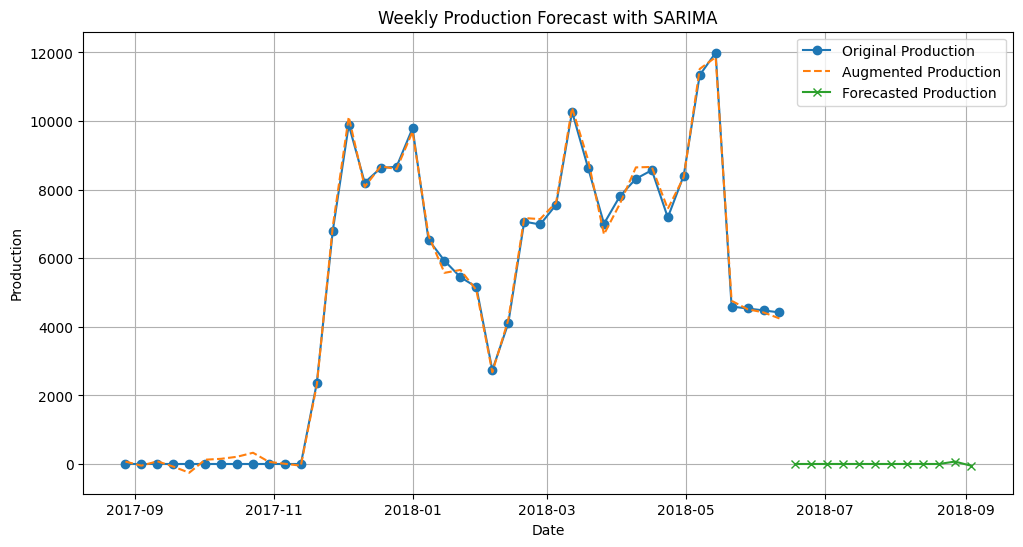

         date  predicted_production
0  2018-06-18              0.000000
1  2018-06-25              0.000000
2  2018-07-02              0.000000
3  2018-07-09              0.000000
4  2018-07-16              0.000000
5  2018-07-23              0.000000
6  2018-07-30              0.000000
7  2018-08-06              0.000000
8  2018-08-13              0.000000
9  2018-08-20              0.000000
10 2018-08-27             69.907375
11 2018-09-03            -49.101474


In [7]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
production_data = pd.read_csv('전북군산생산량_변환.csv')
environment_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 날짜 형식 변환 및 주차 추출
environment_data['measDtStr'] = pd.to_datetime(environment_data['measDtStr'], format='%Y%m%d%H%M%S')
environment_data['연도'] = environment_data['measDtStr'].dt.year
environment_data['주차'] = environment_data['measDtStr'].dt.isocalendar().week
environment_data.rename(columns={'frmhsId': 'item.frmhsId'}, inplace=True)

# 환경 데이터를 주차 단위로 평균 내기
weekly_env_data = environment_data.groupby(['연도', '주차', 'item.frmhsId']).mean(numeric_only=True).reset_index()

# 생산량 데이터와 환경 데이터를 병합
merged_data = pd.merge(production_data, weekly_env_data, how='inner', on=['연도', '주차', 'item.frmhsId'])
merged_data['date'] = pd.to_datetime(merged_data['연도'].astype(str) + '-' + merged_data['주차'].astype(str) + '-1', format='%Y-%W-%w')

# 시계열 데이터로 변환
weekly_production = merged_data[['date', '생산량']].groupby('date').sum().reset_index()
weekly_production.set_index('date', inplace=True)

# 2. SARIMA 모델의 최적 파라미터 찾기
def sarima_grid_search(data, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_aic = float("inf")
    best_params = None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q in itertools.product(P_values, D_values, Q_values):
            try:
                model = SARIMAX(data,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, m),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (p, d, q, P, D, Q, m)
            except:
                continue
    return best_params

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
m = 52  # 주 단위 계절성

# 최적의 파라미터 찾기
best_params = sarima_grid_search(weekly_production['생산량'], p_values, d_values, q_values, P_values, D_values, Q_values, m)
print("Best SARIMA Parameters:", best_params)

# 3. 데이터 증강: 노이즈 추가
def augment_data_with_noise(data, num_copies=5, noise_level=0.05):
    augmented_data = pd.DataFrame()
    for i in range(num_copies):
        noise = np.random.normal(0, noise_level * data.std(), len(data))
        noisy_data = data + noise
        augmented_data = pd.concat([augmented_data, noisy_data], axis=1)
    return augmented_data.mean(axis=1)

augmented_production = augment_data_with_noise(weekly_production['생산량'], num_copies=5, noise_level=0.1)

# 4. 최적 파라미터를 사용하여 SARIMA 모델 학습 및 예측
(p, d, q, P, D, Q, m) = best_params
model = SARIMAX(augmented_production,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_model = model.fit()

# 향후 12주 예측
forecast = sarima_model.forecast(steps=12)
forecast_df = forecast.reset_index()
forecast_df.columns = ['date', 'predicted_production']

# 5. 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(weekly_production.index, weekly_production['생산량'], label='Original Production', marker='o')
plt.plot(augmented_production.index, augmented_production, label='Augmented Production', linestyle='--')
plt.plot(forecast_df['date'], forecast_df['predicted_production'], label='Forecasted Production', marker='x')
plt.title('Weekly Production Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# 6. 예측 결과 출력
print(forecast_df)


In [4]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
production_data = pd.read_csv('전북군산생산량_변환.csv')
environment_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 날짜 형식 변환 및 주차 추출
environment_data['measDtStr'] = pd.to_datetime(environment_data['measDtStr'], format='%Y%m%d%H%M%S')
environment_data['연도'] = environment_data['measDtStr'].dt.year
environment_data['주차'] = environment_data['measDtStr'].dt.isocalendar().week
environment_data.rename(columns={'frmhsId': 'item.frmhsId'}, inplace=True)

# 환경 데이터를 주차 단위로 평균 내기
weekly_env_data = environment_data.groupby(['연도', '주차', 'item.frmhsId']).mean(numeric_only=True).reset_index()

# 생산량 데이터와 환경 데이터를 병합
merged_data = pd.merge(production_data, weekly_env_data, how='inner', on=['연도', '주차', 'item.frmhsId'])
merged_data['date'] = pd.to_datetime(merged_data['연도'].astype(str) + '-' + merged_data['주차'].astype(str) + '-1', format='%Y-%W-%w')

# 시계열 데이터로 변환
weekly_production = merged_data[['date', '생산량']].groupby('date').sum().reset_index()
weekly_production.columns = ['ds', 'y']

# 2. Prophet 모델 학습
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(weekly_production)

# 3. 향후 12주 예측
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# 4. 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(weekly_production['ds'], weekly_production['y'], label='Actual Production', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Production', marker='x')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, label='Confidence Interval')
plt.title('Weekly Production Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# 5. 예측 결과 출력
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [6]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 1. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 2. 주차별 평균 데이터 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'mean',
    'inHd': 'mean',
    'inCo2': 'mean',
    'outTp': 'mean'
}).reset_index()

# 3. 생산량 데이터 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량'])

# Prophet 모델용 데이터 준비
merged_data['날짜'] = pd.to_datetime(merged_data['연도'].astype(str) + merged_data['주차'].astype(str) + '1', format='%Y%W%w')
prophet_data = merged_data[['날짜', '생산량']].rename(columns={'날짜': 'ds', '생산량': 'y'})

# 4. Prophet 모델 학습
model = Prophet(stan_backend='CMDSTANPY')
model.fit(prophet_data)

# 5. 예측 기간 설정 (47주차부터 다음 해 24주차까지)
future = model.make_future_dataframe(periods=30, freq='W')
forecast = model.predict(future)

# 6. 예측 결과 시각화
plt.figure(figsize=(14, 7))
model.plot(forecast)
plt.title('Predicted Weekly Tomato Production using Prophet')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()

# 7. 예측된 데이터 출력
predicted_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(predicted_data)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte

In [4]:
!pip install cmdstanpy

In [8]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# CSV 파일 읽기 (인코딩 문제 해결)
yield_data = pd.read_csv('전북군산생산량_변환.csv', encoding='utf-8-sig')
env_data = pd.read_csv('전북군산환경데이터_변환.csv', encoding='utf-8-sig')

# 1. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 2. 주차별 평균 데이터 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'mean',
    'inHd': 'mean',
    'inCo2': 'mean',
    'outTp': 'mean'
}).reset_index()

# 3. 생산량 데이터 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량'])

# Prophet 모델용 데이터 준비
merged_data['날짜'] = pd.to_datetime(merged_data['연도'].astype(str) + merged_data['주차'].astype(str) + '1', format='%Y%W%w')
prophet_data = merged_data[['날짜', '생산량']].rename(columns={'날짜': 'ds', '생산량': 'y'})

# 4. Prophet 모델 학습 (stan_backend 제거)
model = Prophet()
model.fit(prophet_data)

# 5. 예측 기간 설정 (47주차부터 다음 해 24주차까지)
future = model.make_future_dataframe(periods=30, freq='W')
forecast = model.predict(future)

# 6. 예측 결과 시각화
plt.figure(figsize=(14, 7))
model.plot(forecast)
plt.title('Predicted Weekly Tomato Production using Prophet')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()

# 7. 예측된 데이터 출력
predicted_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print("\n예측된 주차별 생산량 데이터:")
print(predicted_data)


AttributeError: 'Prophet' object has no attribute 'stan_backend'